# This notebook uses the dataset of Park et al. (2016) to illustrate how to compute DGSA sensitivity.

# Provide inputs and load data

In [19]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path

# Add the src directory to the system path
root_path = Path.cwd().parent
sys.path.append(str(root_path / "src"))

# Provide the case name (name model parameter and response data files as case_name_parameters.csv and case_name_responses.csv)
case_name = "Park2016"
# Load model parameter data
df_parameters = pd.read_csv(root_path / 'data' / f'{case_name}_parameters.csv')
print(f"Model parameter data shape: {df_parameters.shape}")
parameter_values = df_parameters.to_numpy()
# extract parameter names from csv header
parameter_names = df_parameters.columns.tolist()
print(f"Parameter names: {parameter_names}")

Model parameter data shape: (1000, 15)
Parameter names: ['oilvis', 'dtmax', 'kvkh', 'mflt1', 'mflt2', 'mflt3', 'mflt4', 'oilexp', 'owc', 'sorw', 'swc', 'watexp', 'scen', 'prop', 'size']


# Perform kmedoids clustering on the model responses

## Option 1: Compute an euclidean distance matrix of model responses 

In [ ]:
from computation.kmedoids import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

# Load model response data
df_responses = pd.read_csv(root_path / 'data' / f'{case_name}_responses.csv')
print(f"Model response data shape: {df_responses.shape}")
response_values = df_responses.to_numpy()

# Compute euclidean distance matrix
distance_matrix = euclidean_distances(response_values)
print(f"Distance matrix shape: {distance_matrix.shape}")

# Perform k-medoids clustering
clustering = kmedoids(
    distance_matrix = distance_matrix, # precomputed distance matrix
    n_clusters = 2, # number of clusters
    n_rep = 5, # number of k-medoid runs to perform
    max_iterations = 50, # maximum number of iterations per run
    )

## Option 2: Provide a distance matrix of model responses (to allow for user specified distance matrix)

In [20]:
from computation.kmedoids import kmedoids

# Load distance matrix
df_distance_matrix = pd.read_csv(root_path / 'data' / f'{case_name}_distance_matrix.csv',header=None)
distance_matrix = df_distance_matrix.to_numpy()
print(f"Distance matrix shape: {distance_matrix.shape}")

# Perform k-medoids clustering
clustering = kmedoids(
    distance_matrix = distance_matrix, # precomputed distance matrix
    n_clusters = 3, # number of clusters
    n_rep = 5, # number of k-medoid runs to perform
    max_iterations = 50, # maximum number of iterations per run
    )

Distance matrix shape: (1000, 1000)
minDist 3169464336.82, iter 1
Kmedoids clustering completed


# Compute the single parameter sensitivity

In [26]:
from computation.single_parameter_sensitivity import single_parameter_sensitivity

single_sensitivity = single_parameter_sensitivity(
    parameter_values = parameter_values, # model parameter values
    clustering = clustering, # clustering results from k-medoids
    alpha = 0.95, # significance level
    n_draws = 3000, # number of bootstrap draws
    random_seed = 42, # random seed for bootstrap sampling
    method = 'l1norm_and_ASL' # sensitivity analysis method
    )

Completed single parameter sensitivity analysis using the l1norm_and_ASL method


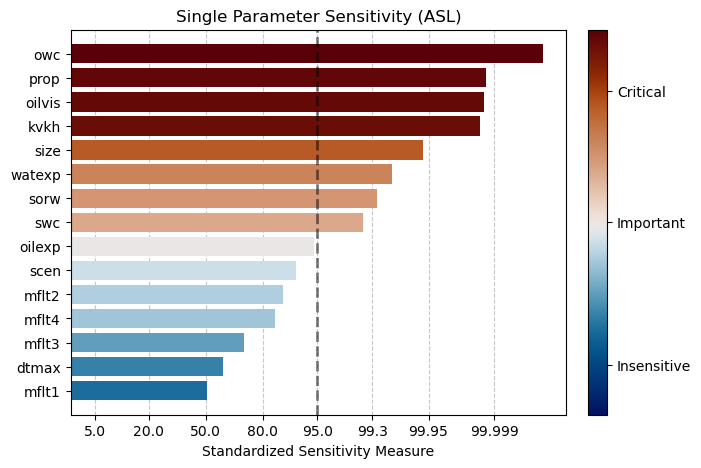

In [27]:
from visualization.single_pareto import single_pareto_standardized

single_pareto_standardized(
    single_sensitivity_results =  single_sensitivity['single_ASL'],
    parameter_names = parameter_names,
    title = "Single Parameter Sensitivity (ASL)",
    fig_size = (7, 5),
    font_size = 10,
    font = 'DejaVu Sans'
)

# Compute single parameter sensitivity for three different alphas (for confindance interval)

In [28]:
from computation.single_parameter_sensitivity import single_parameter_sensitivity

alpha_list = [0.95, 0.91, 0.99] # list of significance levels in the order of medium, low, high
sensitivity_list = []
for alpha in alpha_list:
    single_sensitivity_iter = single_parameter_sensitivity(
        parameter_values = parameter_values, # model parameter values
        clustering = clustering, # clustering results from k-medoids
        alpha = alpha, # significance level
        n_draws = 2000, # number of bootstrap draws
        method = 'l1norm' # sensitivity analysis method
        )

    sensitivity_list.append(single_sensitivity_iter['single_l1norm']['standardized'])

# convert to 2D array (n_parameters, n_alphas)
single_sensitivity_3alphas = np.vstack(sensitivity_list).T
single_sensitivity_3alphas.shape

Completed single parameter sensitivity analysis using the l1norm method
Completed single parameter sensitivity analysis using the l1norm method
Completed single parameter sensitivity analysis using the l1norm method


(15, 3)

# Compute the conditional parameter sensitivity (two-way parameter interaction)

In [24]:
from computation.conditional_parameter_sensitivity import conditional_parameter_sensitivity

conditional_sensitivity = conditional_parameter_sensitivity(
    parameter_values = parameter_values, # model parameter values
    parameter_names = parameter_names, # model parameter names
    clustering = clustering, # clustering results from k-medoids
    alpha = 0.95, # significance level
    n_bins = 3, # number of bins for conditioning
    n_draws = 3000, # number of bootstrap draws
    random_seed = 42, # random seed for bootstrap sampling
    method = 'l1norm_and_ASL' # sensitivity analysis method
    )

Computing sensitivity conditioned on oilvis...
Computing sensitivity conditioned on dtmax...
Computing sensitivity conditioned on kvkh...
Computing sensitivity conditioned on mflt1...
Computing sensitivity conditioned on mflt2...
Computing sensitivity conditioned on mflt3...
Computing sensitivity conditioned on mflt4...
Computing sensitivity conditioned on oilexp...
Computing sensitivity conditioned on owc...
Computing sensitivity conditioned on sorw...
Computing sensitivity conditioned on swc...
Computing sensitivity conditioned on watexp...
Computing sensitivity conditioned on scen...
Computing sensitivity conditioned on prop...
Computing sensitivity conditioned on size...
Completed conditional parameter sensitivity analysis using the l1norm_and_ASL method


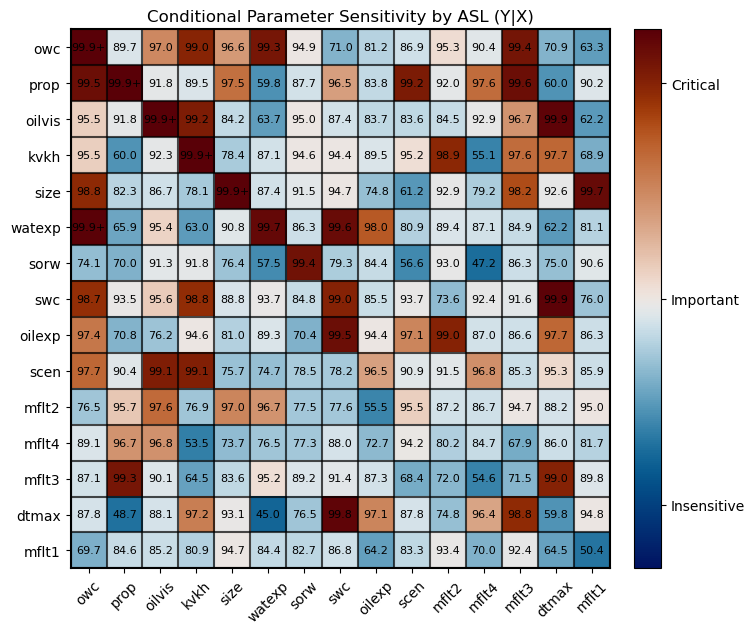

In [29]:
from visualization.conditional_heatmap import conditional_heatmap_standardized

conditional_heatmap_standardized(
    single_sensitivity_results =  single_sensitivity['single_ASL'], 
    conditional_sensitivity_results = conditional_sensitivity['conditional_ASL'],
    parameter_names = parameter_names,
    title = "Conditional Parameter Sensitivity by ASL (Y|X)",
    fig_size = (8, 7),
    font = 'DejaVu Sans',
    font_size = 10,
    show_values = True
)

# Save results

In [30]:
from utils.DGSA_save_load import DGSA_save
# Combine results
DGSA_results = {}
DGSA_results['single_l1norm'] = single_sensitivity['single_l1norm']
DGSA_results['single_ASL'] = single_sensitivity['single_ASL']
DGSA_results['single_l1norm_standardized_3alphas'] = single_sensitivity_3alphas
DGSA_results['conditional_l1norm'] = conditional_sensitivity['conditional_l1norm']
DGSA_results['conditional_ASL'] = conditional_sensitivity['conditional_ASL']
DGSA_results['distance_matrix'] = distance_matrix
DGSA_results['clustering'] = clustering
DGSA_results['parameter_names'] = parameter_names

# Save results
DGSA_save(DGSA_results, root_path / 'results' / f'{case_name}_DGSA_results.pkl')